<a href="https://colab.research.google.com/github/SilvaPJS/Universo-Multimensageiro-de-Alta-Energia/blob/main/open_science_matched_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Universo Multimensageiro de Alta Energia na Nova Era de Telescópios**
## **Open Science: Matched Filtering**

**Pedro J. S. Silva**  
pedro.jeronimo@unesp.br

# **Detecção com Matched Filtering (GW150914)**

## Preparação do ambiente

Nesta etapa, vamos instalar/atualizar os pacotes necessários para a continuação do minicurso.

- **GWpy**: baixar e manipular dados reais (TimeSeries), além de ferramentas de visualização.
- **PyCBC**: gerar templates (formas de onda) e aplicar **matched filtering** para obter a série temporal de SNR.
- **Astropy / SciPy / Matplotlib**: suporte científico (tempo, processamento e gráficos).

> **Observação importante:** se você estiver rodando em Colab, essas instalações normalmente funcionam direto.  


## Instalação das bibliotecas

In [ ]:
!pip install --upgrade astropy
!pip install --upgrade matplotlib
!pip install --upgrade scipy
!pip install --upgrade gwpy
!pip install --upgrade pycbc



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 46.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Importações e verificação de versões

Antes de iniciar a análise, é boa prática registrar as versões das bibliotecas utilizadas.  
Isso ajuda na **reprodutibilidade**: caso alguém execute este notebook no futuro, será possível comparar diferenças de comportamento entre versões.

Nesta parte, vamos usar:

- `gwpy` para lidar com séries temporais e funções de processamento/plot
- `gwosc` para obter informações do evento (tempo GPS)
- `pycbc` para gerar templates e aplicar *matched filtering*


In [ ]:
import gwpy
print(gwpy.__version__)
import astropy
print(astropy.__version__)
import pycbc
print(pycbc.__version__)
%matplotlib inline

/usr/local/lib/python3.12/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


3.0.13
7.2.0
2.10.0


## Evento GW150914 e escala de tempo

Vamos trabalhar com o evento **GW150914**, a primeira detecção direta de ondas gravitacionais feita pelo LIGO.

Os tempos associados aos eventos de ondas gravitacionais são expressos em **tempo GPS**, que é uma escala contínua amplamente utilizada em experimentos espaciais e de física fundamental.

A partir do catálogo público do GWOSC, podemos obter automaticamente o tempo GPS associado ao evento e, em seguida, definir uma janela temporal ao redor desse instante para análise.


In [ ]:
from gwosc.datasets import event_gps

gps = event_gps('GW150914')
print("Tempo GPS do evento GW150914:", gps)


Tempo GPS do evento GW150914: 1126259462.4


Em vez de analisar apenas o instante exato do evento, selecionamos uma **janela de tempo mais ampla** ao redor do sinal.

Isso é importante porque:
- o ruído do detector precisa ser caracterizado antes e depois do evento;
- métodos como o *matched filtering* utilizam essa informação para distinguir sinal físico de flutuações do ruído.


In [ ]:
start_time = 1126259446
end_time   = 1126259478

print("Início da janela:", start_time)
print("Fim da janela:", end_time)
print("Duração (s):", end_time - start_time)


Início da janela: 1126259446
Fim da janela: 1126259478
Duração (s): 32


## Dados reais do detector LIGO–Hanford (H1)

Nesta etapa, vamos baixar dados reais do detector **LIGO–Hanford (H1)** diretamente do repositório público do GWOSC.

Os dados são retornados como uma **série temporal**, que contém tanto o sinal astrofísico quanto o ruído instrumental do detector.
Trabalhar com dados reais é fundamental para entender os desafios associados à detecção de ondas gravitacionais.


In [ ]:
from gwpy.timeseries import TimeSeries

data = TimeSeries.fetch_open_data('H1', start_time, end_time)

O objeto retornado é uma `TimeSeries`, que armazena:
- os valores do strain medido pelo detector;
- o intervalo de amostragem;
- as informações de tempo associadas a cada ponto.

A partir desse objeto, podemos aplicar filtros, calcular a densidade espectral de potência e converter os dados para outros formatos quando necessário.


## Pré-processamento: filtro passa-alta

Os dados do LIGO contêm contribuições de ruído em baixas frequências, principalmente associadas a efeitos sísmicos e ambientais.

Como os detectores terrestres têm baixa sensibilidade abaixo de algumas dezenas de hertz, aplicamos um **filtro passa-alta** para remover essas componentes de baixa frequência antes da análise.


In [ ]:
high = data.highpass(15)

<TimeSeries([ 1.38752520e-20,  6.18965968e-21,  3.83850846e-20,
             ..., -3.59967360e-20, -9.23100986e-21,
              2.02155349e-21]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625945e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

O corte em **15 Hz** é uma escolha comum em análises introdutórias, pois:
- remove grande parte do ruído sísmico;
- preserva a faixa de frequências onde o sinal do evento GW150914 é dominante.

A partir deste ponto, trabalharemos com os dados filtrados.


## Densidade espectral de potência (PSD) e janela temporal

Para aplicar *matched filtering*, precisamos de um modelo do **ruído do detector**.  
Essa informação é fornecida pela **densidade espectral de potência (PSD)**, que descreve como a potência do ruído se distribui em frequência.

Além disso, vamos selecionar uma **janela temporal menor**, centrada próximo ao evento, onde o sinal de ondas gravitacionais está presente.


In [ ]:
psd = high.psd(4, 2)

<FrequencySeries([9.28845442e-47, 4.64373057e-47, 2.54809502e-53,
                  ..., 4.24278459e-50, 2.80526205e-50,
                  4.89488597e-51]
                 unit=Unit("1 / Hz"),
                 f0=<Quantity 0. Hz>,
                 df=<Quantity 0.25 Hz>,
                 epoch=<Time object: scale='utc' format='gps' value=1126259446.0>,
                 name='Strain',
                 channel=None)>

Embora a janela inicial contenha dezenas de segundos de dados, o sinal de GW150914 dura apenas uma fração de segundo.

Por isso, recortamos uma janela temporal menor ao redor do evento, que será usada diretamente no cálculo da correlação com o template.


In [ ]:
zoom = high.crop(1126259460, 1126259464)

<TimeSeries([ 1.62568571e-21,  8.70980367e-21, -1.33800046e-20,
             ...,  5.81321935e-21,  5.62934767e-22,
             -1.38089790e-20]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625946e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

## (Agora é com vocês!**) Forma de onda no domínio do tempo

Antes de aplicarmos o *matched filtering*, vamos explorar a forma de onda gravitacional
no **domínio do tempo**, usando diretamente modelos teóricos da Relatividade Geral.

Este exemplo tem caráter **exploratório**:
- os estudantes podem variar massas,
- testar diferentes aproximantes,
- observar como o formato do sinal muda.

Nesta etapa, **não estamos tentando detectar o sinal em dados reais**,
apenas compreender a física por trás da forma de onda.


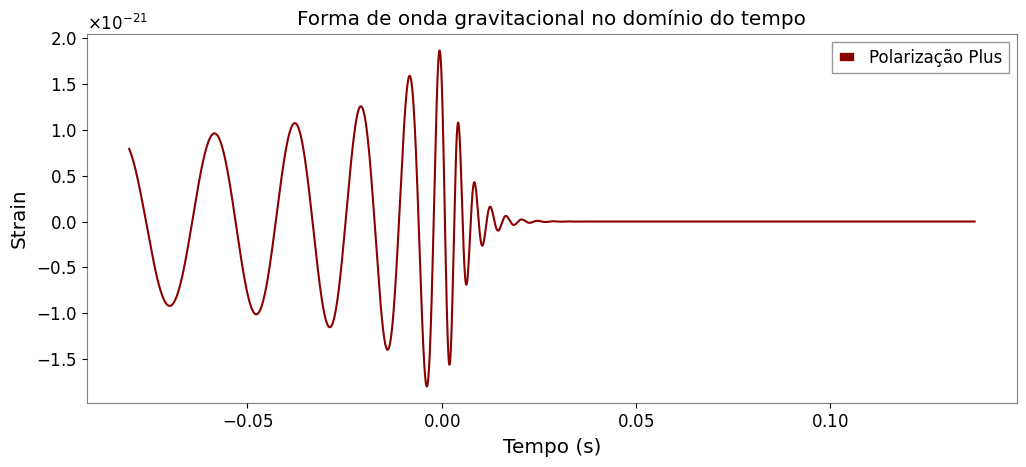

In [ ]:
from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(
      approximant="SEOBNRv4_opt",
    mass1=32,
    mass2=40,
    delta_t=1.0/16384.0,
    f_lower=40,
    distance=450
)

cor_onda = 'darkred'   # exemplos: 'blue', 'green', 'black', 'orange'

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp,
           label='Polarização Plus',
           color=cor_onda)

pylab.xlabel('Tempo (s)')
pylab.ylabel('Strain')
pylab.title('Forma de onda gravitacional no domínio do tempo')
pylab.legend()
pylab.grid()
pylab.show()



### Aproximantes que podem ser explorados neste exemplo

Os aproximantes descrevem diferentes níveis de modelagem física para sistemas binários compactos.
Neste bloco (domínio do tempo), você pode testar, por exemplo:

- **SEOBNRv4_opt**  

- **SEOBNRv4**  
  Versão completa do modelo EOB, mais custosa computacionalmente.

- **TaylorT4**  
  Aproximação pós-newtoniana no domínio do tempo (válida principalmente no inspiral).

- **IMRPhenomD**


## Template para o *matched filter*

Para detectar um sinal fraco imerso em ruído, utilizamos um **template**, isto é, uma forma de onda prevista teoricamente a partir da Relatividade Geral.

No caso de sistemas binários compactos, como pares de buracos negros, a forma de onda pode ser dividida em três fases:
- *inspiral* (espiralamento),
- *merger* (fusão),
- *ringdown* (relaxação do objeto final).

Nesta análise, vamos gerar um template no **domínio da frequência**, compatível com a PSD estimada anteriormente.


In [ ]:
from pycbc.waveform import get_fd_waveform

from pycbc.waveform import get_fd_waveform
hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                        f_lower=30, f_final=2048, delta_f=psd.df.value)

Alguns pontos importantes sobre o template gerado:

- O modelo **IMRPhenomD** descreve todas as fases do sinal (*inspiral–merger–ringdown*).
- As massas escolhidas são compatíveis com o evento GW150914.
- O template é construído no domínio da frequência, o que facilita o uso no *matched filtering*.
- O parâmetro `delta_f` garante que o template tenha a mesma resolução em frequência que a PSD.


Antes de aplicar o *matched filtering*, o template precisa ser corretamente alinhado no tempo.

O algoritmo de correlação irá deslizar o template ao longo dos dados,
buscando o instante em que a semelhança entre ambos é máxima.



In [ ]:
template = hp.cyclic_time_shift(hp.start_time)

Agora aplicamos o **matched filtering**, que calcula a correlação ótima entre
o template teórico e os dados reais, levando em conta o ruído do detector.

O resultado é uma série temporal de **razão sinal-ruído (SNR)**.


In [ ]:
from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=15)

A série de SNR indica, para cada instante de tempo,
o quão bem o template se correlaciona com os dados reais.

Picos nessa série são candidatos a eventos físicos.


In [ ]:
from gwpy.timeseries import TimeSeries
snrts = TimeSeries.from_pycbc(snr).abs()

## Visualização da SNR ao redor do evento

Vamos visualizar a série temporal de SNR em uma janela curta ao redor do evento.
O objetivo é identificar claramente o pico associado ao GW150914 no detector H1.



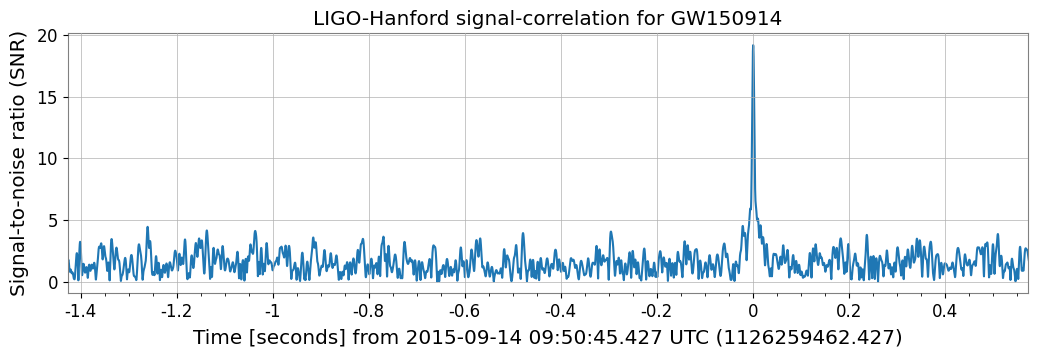

In [ ]:
plot = snrts.plot()
ax = plot.gca()

ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)

ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')

plot.show()

Agora vamos localizar automaticamente o máximo da SNR, obtendo:

- o instante de tempo (GPS) em que ocorre o pico;
- o valor máximo de SNR associado.

Esse é um exemplo simples de como um algoritmo pode identificar um candidato a evento.


In [ ]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("Encontramos um sinal em {} s com SNR {}".format(time, abs(snrp)))

Encontramos um sinal em 1126259462.4282227 s com SNR 19.187718042746027


# Informações complementares

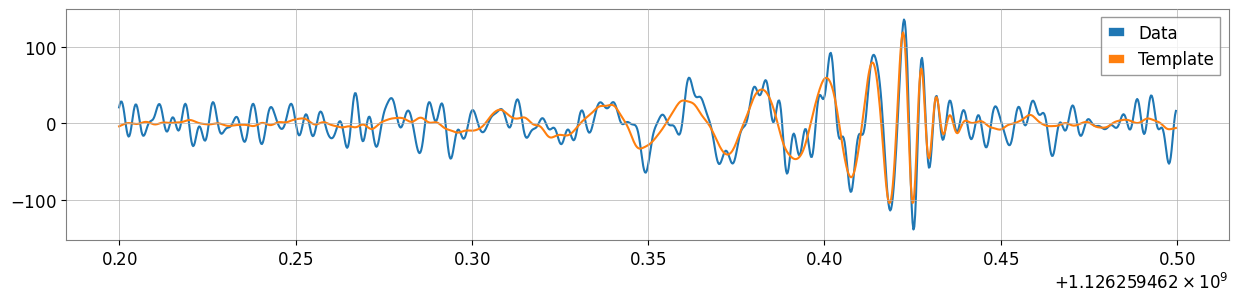

In [ ]:
from pycbc.filter import sigma
import numpy as np

dt = time - zoom.times.value[0]
shift_samples = int(round(dt * zoom.sample_rate.value))
aligned_template = template.cyclic_time_shift(shift_samples / zoom.sample_rate.value)

aligned_template /= sigma(aligned_template, psd=psd.to_pycbc(), low_frequency_cutoff=20.0)

aligned_template = (aligned_template.to_frequencyseries() * snrp).to_timeseries()
aligned_template.start_time = zoom.times.value[0]

white_data = (zoom.to_pycbc().to_frequencyseries() / psd.to_pycbc()**0.5).to_timeseries()
tapered = aligned_template.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd.to_pycbc()**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

merger_time = gps
white_data = white_data.time_slice(merger_time - 0.2, merger_time + 0.1)
white_template = white_template.time_slice(merger_time - 0.2, merger_time + 0.1)

import pylab

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()


## Teste de consistência

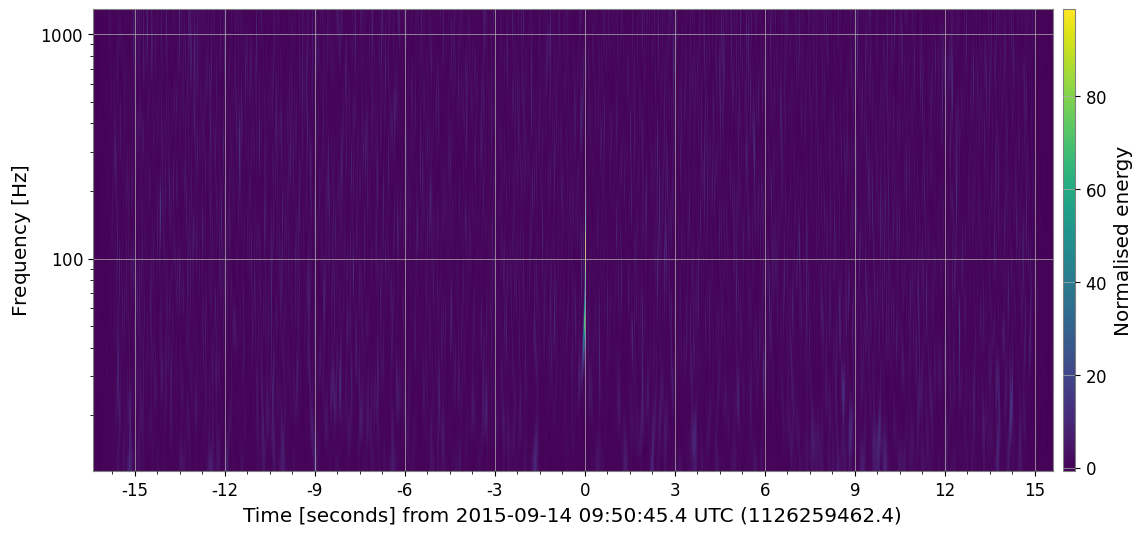

In [ ]:
hq = data.q_transform()
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

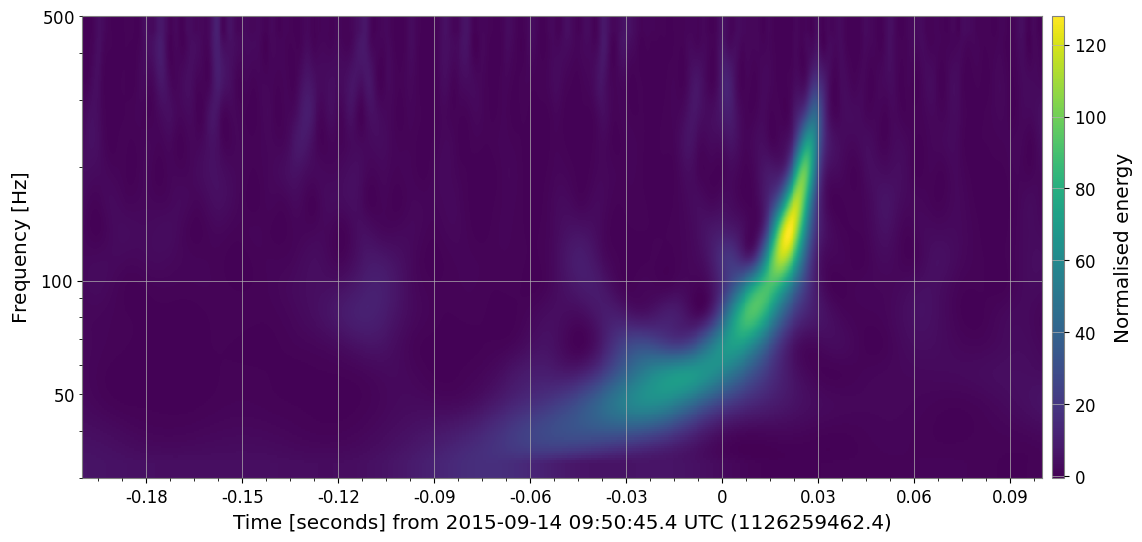

In [ ]:
hq2 = data.q_transform(frange=(30, 500), outseg=(gps-0.2,gps+0.1))
plot = hq2.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

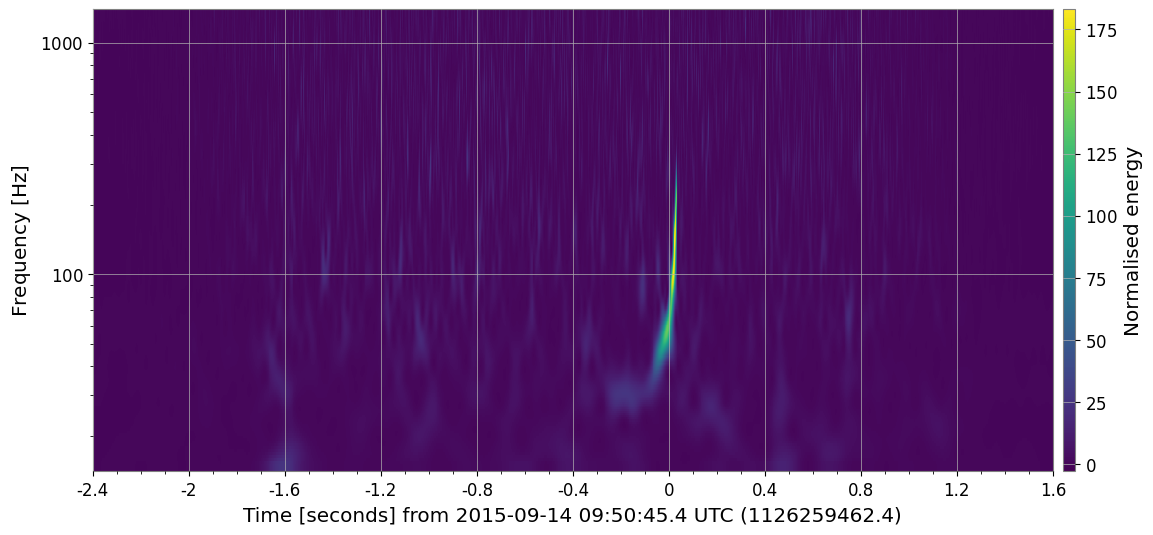

In [ ]:
twoq = zoom.q_transform(qrange=(5,10))
plot = twoq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")


In [ ]:
print('zoom:' + str(zoom))

print('align_template:' + str(aligned_template))

aligned_template = TimeSeries(aligned_template, sample_rate=zoom.sample_rate, epoch=zoom.epoch)


zoom:TimeSeries([ 1.62568571e-21,  8.70980367e-21, -1.33800046e-20,
            ...,  5.81321935e-21,  5.62934767e-22,
            -1.38089790e-20]
           unit: dimensionless,
           t0: 1126259460.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)
align_template:[-6.91739822e-24 -7.07248009e-24 -7.22100850e-24 ...
 -6.41419056e-24 -6.58810737e-24 -6.75589448e-24]


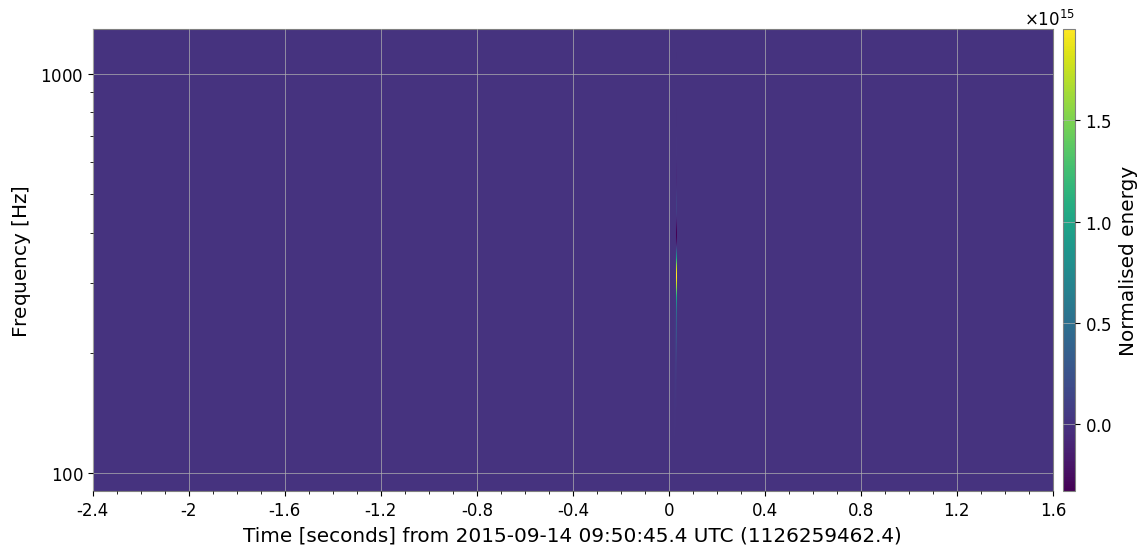

In [ ]:
aq = aligned_template.q_transform()
plot = aq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")


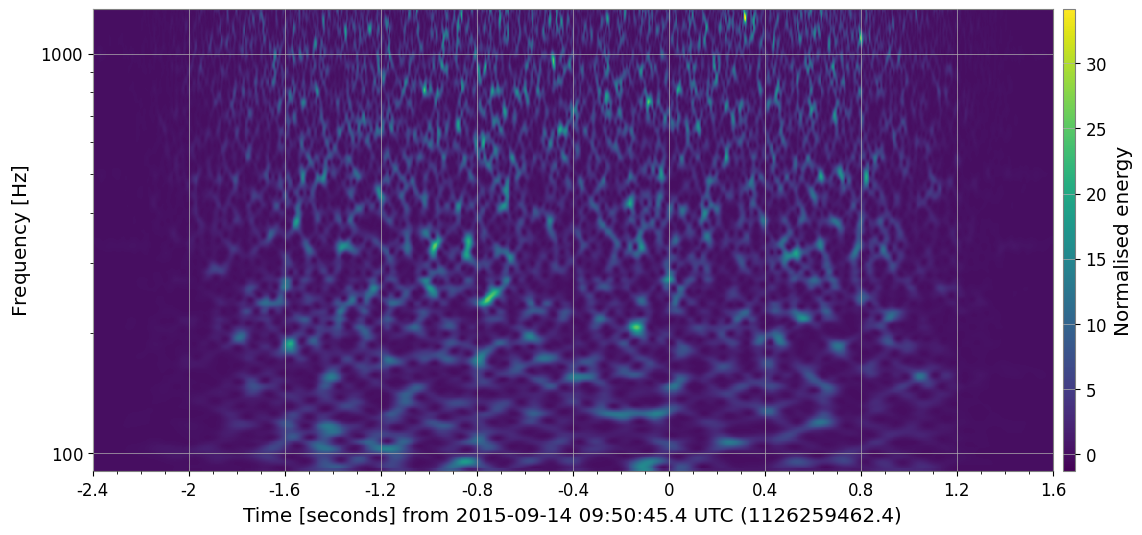

In [ ]:
sub = zoom - aligned_template


Qsub = sub.q_transform()
plot = Qsub.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

# **Hands-on**

### 1) Variação de massas no matched filtering

Repita o procedimento de *matched filtering* para o evento **GW150914**, variando os valores das massas do sistema binário.

Sugestões:
- mantenha o mesmo aproximante utilizado no minicurso;
- teste diferentes combinações de `mass1` e `mass2`.

Para cada combinação de massas, registre:
- o valor máximo da SNR;
- o instante de tempo em que ocorre o pico da SNR.

Compare os resultados e discuta:
- como a SNR depende da escolha das massas;
- quais combinações produzem maior correlação com os dados reais.


### 2) Grade simples de massas

Construa uma pequena grade de valores de massa e aplique o *matched filtering* para cada ponto da grade.

Sugestão de intervalo:
- `mass1` entre 20 e 60 $(M_\odot)$;
- `mass2` entre 10 e 60 $(M_\odot)$, com `mass2 ≤ mass1`.

Organize os resultados em uma tabela contendo:
- `mass1`;
- `mass2`;
- SNR máxima;
- tempo do pico da SNR.

Comente quais regiões do espaço de massas apresentam maior sensibilidade para o evento analisado.

### 3) Aplicação a outro evento

Escolha **outro evento de ondas gravitacionais** disponível no catálogo público do GWOSC e repita a análise de *matched filtering*.

Siga o mesmo procedimento utilizado para o GW150914:
- obtenha o tempo GPS do evento;
- selecione uma janela temporal adequada;
- gere um template no domínio da frequência;
- calcule a SNR e identifique o pico.

Compare os resultados com os obtidos para o GW150914 e discuta possíveis diferenças em termos de:
- massas estimadas;
- duração do sinal;
- valor máximo da SNR.